In [75]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import math
import datetime

## stat imports
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import linregress

#import researchpy as rp
import scipy.stats as stats
from scipy.stats import skew 


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option("max_rows", 150)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
#reset pd.reset_option('display.float_format')

from numpy import linalg as LA

from IPython.display import clear_output



## Plotly
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

# Others
import nltk
import string
import re
from collections import Counter
from matplotlib import pyplot

from nltk.tokenize import sent_tokenize, word_tokenize 
import gensim 
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim import models

from nltk.stem import SnowballStemmer
nltk.download('stopwords')

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.manifold import TSNE

import csv

from sklearn import decomposition
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


## running NN models

import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F
import torch

#torch.manual_seed(1)

from collections import defaultdict

from torch.optim.optimizer import Optimizer
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import shutil

import torchtext
from torchtext import data

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import os


#critical function spacing print
def v():
  print("\n")
  return None

v()
print("[[IMPORT OK]]")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/aryavish/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True



[[IMPORT OK]]


In [3]:
!pwd


from google.colab import drive
drive.mount('/content/drive') 

/content
Mounted at /content/drive


In [4]:
os.chdir("/content/drive/My Drive/Capcelona/Deals/Bus Dev/coursera review crap/math review/GMU Dept of Math/pred ana/OR 610 DLNN/hw/proj")

In [76]:
#TORCHTEXT
#==================================

#import data using torchtext


import torchtext
from torchtext import data

train_csv_name = 'xtrain_exp.csv'
test_csv_name = 'xtest_exp.csv'

min_word_freq = 5 #tokenization vocab build

BATCH_SIZE = 1000



label_field = data.Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = data.Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)

fields = [('target', label_field), ('clean_tweet', text_field)]

trainds, testds = data.TabularDataset.splits(path= ".", format='csv', train= train_csv_name, test= test_csv_name, fields=fields, skip_header=True)

text_field.build_vocab(trainds, min_freq=min_word_freq)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



train_iterator, test_iterator = data.BucketIterator.splits(datasets=(trainds, testds), 
                                                           batch_sizes=(BATCH_SIZE, BATCH_SIZE), 
                                                           sort_key=lambda x: len(x.clean_tweet), 
                                                           sort_within_batch=True, 
                                                           device=device)

In [77]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(f"is Cuda available? ","Yes" if torch.cuda.is_available() else "No")



is Cuda available?  No


In [78]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [79]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    if val_history == 0: # used for gradient plot only
        None
    else:
        points = np.array(val_history)    
        plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
        
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()
    


In [80]:
#train and validate model

def train_val(model,opt,train_options):


    iters = 0
    test_batchcomplete = 50 # compare with iter
    acc_log, loss_log, val_acc_log, val_loss_log = [], [], [], []
    grads, grads_log = [], []
    clip = 5 ## doesn't appear to be exploding gradient issue
    
    EPOCHS = train_options["EPOCHS"]
    KERNEL_SIZE = train_options["KERN_SET"]
    induce_clip = train_options["clip"]


    model.train()
    # Training loop
    for epoch in range(EPOCHS):
        # Iterate over all the batchesb
        for batch in train_iterator:
            # Reset gradients
            opt.zero_grad()

            # Get the data and lengths from the batch
            data, data_lengths = batch.clean_tweet

            ##for multiple filters ensure seq length >= max filter

            if data.shape[1] < max(KERNEL_SIZE):
                tdata = data.detach()
                taddy = torch.zeros([tdata.shape[0], max(KERNEL_SIZE) - tdata.shape[1]])
                fin = torch.cat((tdata,taddy),dim=1)
                data = fin.type(torch.LongTensor)

            #data, data_lengths, batch.target = clean_seq(data, data_lengths, batch.target)

            data = data.to(device)
            data_lengths = data_lengths.to(device)
            target = batch.target.to(device)
            # Calculate loss and accuracy

            #data_lengths = data_lengths.type(torch.IntTensor)
            #print("he: ", data.shape, len(data_lengths))
            outputs = model(data).squeeze()

            loss = criterion(outputs, target)
            accuracy = binary_accuracy(outputs, target)

            #print("\n train accuracy: ", accuracy.item())

            # Backpropagate the loss
            loss.backward()
            
            #clip the gradient
            if induce_clip:
                nn.utils.clip_grad_norm_(model.parameters(), clip)


            # Update model parameters 
            opt.step()      

            #compute gradient vector dl/dv, v in total model parameters
            grads = []
            for param in model.parameters():
                grads.append(param.grad.view(-1))
            grads = torch.cat(grads)
            global tgrad
            tgrad = grads
            grads_log.append(np.linalg.norm(grads.detach().numpy()))
            
            #assert False,"VISH1"
                #print(grads.shape)
            

            iters +=1
            acc_log.append(accuracy.item())
            loss_log.append(loss.item())

        # train complete per epoch, validate below
        val_loss, val_acc = test_model(model)

        val_loss_log.append((iters * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((iters * (epoch + 1), np.mean(val_acc)))

        clear_output()
        plot_history(loss_log, val_loss_log, title='loss')
        plot_history(acc_log, val_acc_log, title='acc')
        plot_history(grads_log,0,title="gradient norm")


        iters = 0 #reset for next epoch
        model.train() # turned off in val test





In [81]:
## PLOT PCA EMBEDDDINGS

def plot_pca(model):
    mweights = model.embedding.weight.detach().numpy()
    words = text_field.vocab.stoi

    pca_matrix = np.zeros((mweights.shape[0], mweights.shape[1]))

    for word, i in words.items():
        try:
            embedding_vector = mweights[i]
        except Exception:
            embedding_vector = None
            pass
        if embedding_vector is not None:
            pca_matrix[i] = embedding_vector


    glove_weights = pca_matrix

    # fit a 2d PCA model to the vectors
    pca = decomposition.PCA(n_components=2)

    pca.fit(glove_weights)

    X = pca.transform(glove_weights)

    X.shape

    result = X

    pyplot.figure(figsize=(20,10))
    pyplot.scatter(result[:, 0], result[:, 1])

    for word, i in words.items(): #annotate first 50 words
        if i > 50:
            break
        elif i < 3:
            None
        else:
            pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))



    pyplot.show()
    
    return None


In [82]:
def test_model(model, opt=None, epoch=None, KERNEL_SIZE=[5]):
    
    test_iters = 0
    preds = np.array([])
    labels = np.array([])
    acc = []
    acc_log = []
    loss_log = []

    model.eval()
    with torch.no_grad():
          for batch in test_iterator:
              
            data,data_lengths = batch.clean_tweet

            #data, data_lengths, batch.target = clean_seq(data, data_lengths, batch.target)
            
            ##for multiple filters ensure seq length >= max filter
        
            if data.shape[1] < max(KERNEL_SIZE):
                tdata = data.detach()
                taddy = torch.zeros([tdata.shape[0], max(KERNEL_SIZE) - tdata.shape[1]])
                fin = torch.cat((tdata,taddy),dim=1)
                data = fin.type(torch.LongTensor)


            data = data.to(device)
            data_lengths = data_lengths.to(device)
            target = batch.target.to(device)


            outputs = model(data).squeeze()
            # preds = np.append(preds, torch.round(outputs).detach().cpu().numpy()) #not sure this right
            # labels = np.append(labels, target.detach().cpu().numpy()) # not sure this right
            loss = criterion(outputs, target)
            accuracy = binary_accuracy(outputs, target) #avg accuracy in batch

            acc_log.append(accuracy.item())
            loss_log.append(loss.item())

            test_iters += 1

    avg_acc = sum(acc_log) / len(acc_log) #avg accuracy in test
    avg_loss = sum(loss_log) / len(loss_log)
    
    return avg_loss, avg_acc


In [83]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

def conf_matrix(label_pred, threshold=.50):

    # uses sigmoid activation
    
    v1 = np.array(label_pred)
    tlabel = [v1[x,0].item() for x in range(v1.shape[0])]
    tsig = [torch.sigmoid(v1[x,1]).detach().numpy().item() for x in range(v1.shape[0])]
    tsig = [1 if tsig[x] >= threshold else 0 for x in range(len(tsig))]
    
    labels = np.unique(tlabel)

    a =  metrics.confusion_matrix(tlabel, tsig, labels=labels)

    print("\n Confusion matrix \n")
    print("\n ",pd.DataFrame(a, index=labels, columns=labels))
    #ACTUAL ROWS, PRED COLS
    print("\n actual are rows, predicted are cols")
    return None

<B> RUN DEEP LEARNING MODELS BELOW HERE, NO METHODS TO BE WRITTEN BELOW THIS LINE </B>

In [84]:
## pytorch CNN 1D
# ======================


class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, output_dim, 
                 dropout, pad_idx, k_size):
        
        super().__init__()
                
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        self.cnn = nn.ModuleList([nn.Conv1d(in_channels = embedding_dim, 
                                              out_channels = n_filters, 
                                              kernel_size = fs) 
                                    for fs in k_size
                                    ])
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(len(k_size)*n_filters, output_dim) #replaced with avg pool torch.mean
        
        
        
    def forward(self, text):
                
            #text = [batch size, sent len]

            embedded = self.embedding(text)

            #embedded = [batch size, sent len, emb dim]

            # transpose and prepare for 1d convolution
            
            embedded = embedded.reshape(embedded.shape[0],embedded.shape[2],embedded.shape[1]) 

            #embedded = [batch size, emb_dim, sent len]

            conved = [F.relu(c(embedded)) for c in self.cnn]

            #conved = [batch size, n_filters, sent len - kernsel_size + 1]

            pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]

            #out = [batch size, filters x kernel]
            
            cat = torch.cat(pooled, dim = 1)
            
            out = self.dropout(cat)
            
            final = self.fc(out)
            
            #final = out.mean(1) 
            
            #final = [batch size, E(filters)] replaces fc
            
            
            return final
            






In [89]:
INPUT_DIM = len(text_field.vocab)+1
EMBEDDING_DIM = 100
PRETRAINED_EMBEDDINGS = None
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
PAD_IDX = text_field.vocab.stoi[text_field.unk_token] ## passed to embedding layer to set 0 vector
DROPOUT = 0.3
N_FILTERS = 32
KERNEL_SIZE = [2,3,4]

EPOCHS = 5

train_options = dict(EPOCHS=10, clip=True, KERN_SET=KERNEL_SIZE)

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, OUTPUT_DIM, DROPOUT, PAD_IDX, KERNEL_SIZE)

opt = optim.Adam(model.parameters())

criterion = nn.BCEWithLogitsLoss() 


print(f'The model has {count_parameters(model):,} trainable parameters')

print(model)

train_options

The model has 829,193 trainable parameters
CNN(
  (embedding): Embedding(8002, 100, padding_idx=0)
  (cnn): ModuleList(
    (0): Conv1d(100, 32, kernel_size=(2,), stride=(1,))
    (1): Conv1d(100, 32, kernel_size=(3,), stride=(1,))
    (2): Conv1d(100, 32, kernel_size=(4,), stride=(1,))
  )
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=96, out_features=1, bias=True)
)


{'EPOCHS': 10, 'clip': True, 'KERN_SET': [2, 3, 4]}

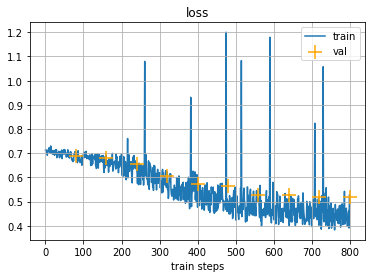

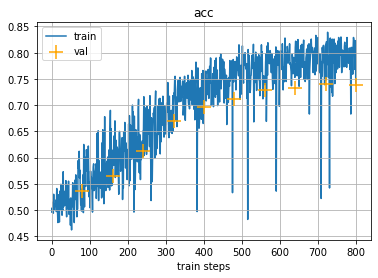

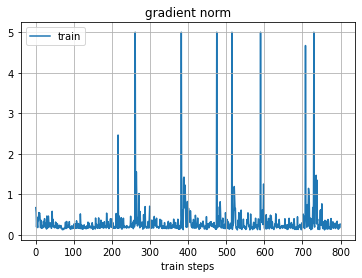

In [90]:
#run model and test

train_val(model,opt,train_options)

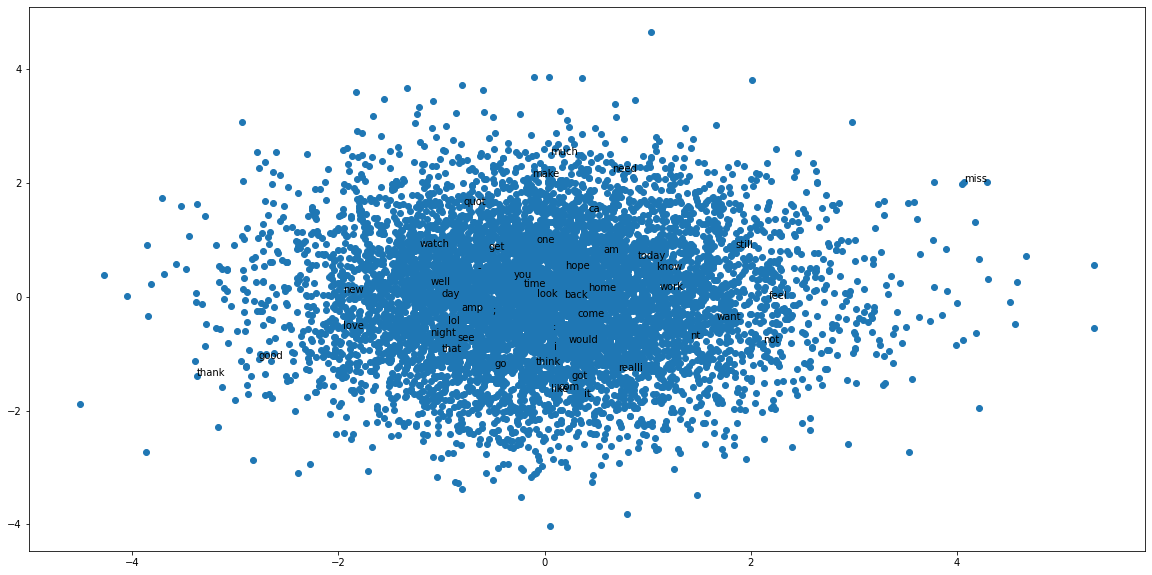

In [91]:
plot_pca(model)

In [92]:
## pytorch CNN2D
# ======================


class CNN_2d(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx, pretrain):
        
        super().__init__()
                
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        if pretrain is not None:
            self.embedding.weight.data.copy_(pretrain) #turn off autograd?
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
                
            #text = [batch size, sent len]

            embedded = self.embedding(text)

            #embedded = [batch size, sent len, emb dim]

            embedded = embedded.unsqueeze(1)

            #embedded = [batch size, 1, sent len, emb dim]

            conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]

            #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]

            pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]

            #pooled_n = [batch size, n_filters]

            cat = self.dropout(torch.cat(pooled, dim = 1))

            #cat = [batch size, n_filters * len(filter_sizes)]
            
            return self.fc(cat)
           



In [94]:
## instantiate CNN2d and test

INPUT_DIM = len(text_field.vocab)+1
EMBEDDING_DIM = 100
PRETRAINED_EMBEDDINGS = None # || set to None otherwise
OUTPUT_DIM = 1
PAD_IDX = text_field.vocab.stoi[text_field.unk_token] ## passed to embedding layer to set 0 vector
DROPOUT = 0.5
N_FILTERS = 32
FILTER_SIZES = [2,3,4]

train_options = dict(EPOCHS=10, clip=False, KERN_SET=KERNEL_SIZE)

model2d = CNN_2d(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX, PRETRAINED_EMBEDDINGS)

opt2d = optim.Adam(model2d.parameters())

criterion = nn.BCEWithLogitsLoss() 


print(f'The model has {count_parameters(model2d):,} trainable parameters')

print(model2d)

print(train_options)


The model has 829,193 trainable parameters
CNN_2d(
  (embedding): Embedding(8002, 100, padding_idx=0)
  (convs): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(2, 100), stride=(1, 1))
    (1): Conv2d(1, 32, kernel_size=(3, 100), stride=(1, 1))
    (2): Conv2d(1, 32, kernel_size=(4, 100), stride=(1, 1))
  )
  (fc): Linear(in_features=96, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
{'EPOCHS': 10, 'clip': False, 'KERN_SET': [2, 3, 4]}


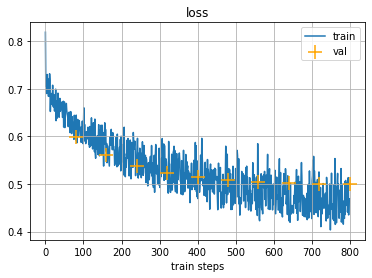

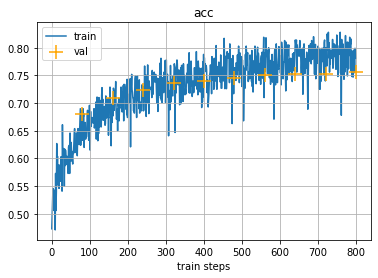

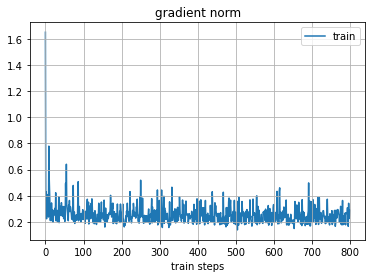

In [95]:
#run model and test

train_val(model2d,opt2d,train_options)

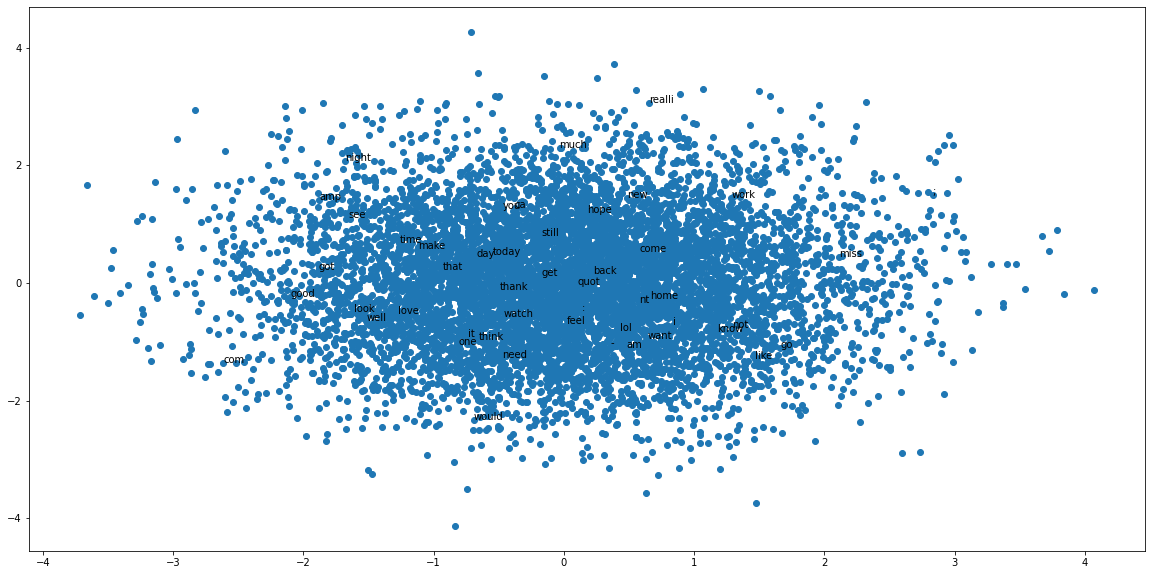

In [96]:
plot_pca(model2d)

In [1]:
## BACKUPS DELETE BELOW THIS BEFORE GIT UPLOAD *****************************************